# IASI data availability

In [43]:
import math, os, re, warnings
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import xarray as xr
import cudf

## Helper functions

In [73]:
def to_datetime(filename):
    try:
        mat = re.search(r'(\d{4}\d{1,2}\d{1,2})', filename)
        s = mat.group()
        fmt = '%Y%m%d'
        return datetime.strptime(s, fmt)
    except:
        warnings.warn('Invalid input')

def to_julian(filename):
    try:
        return to_datetime(filename).timetuple().tm_yday
    except:
        warnings.warn('Invalid date')
        
def lon_to_idx(lon, resolution = 1):
    return math.trunc((180 + lon) / resolution)

def lat_to_idx(lat, resolution = 1):
    return math.trunc((90 + lat) / resolution)

def container(resolution = 1):
    width = round(360 / resolution)
    height = round(180 / resolution)
    return np.zeros(width * height).reshape(width, height)

## Checking for missing measurements

In [71]:
def check_missing(year):
    datadir = f'/home/ubuntu/Data/IASI/METOPA/NH3/{year}'
    files = os.listdir(datadir)
    files.sort()
    files = list(filter(lambda x: 'nh3' in x, files))
    d = dict()
    last_day = to_julian(str(year) + '1231')
    for i in range(1, last_day + 1):
        d[i] = 0
    for file in files:
        d[to_julian(file)] += 1
    for i in range(1, last_day + 1):
        if d[i] < 2:
            print(datetime(year, 1, 1) + timedelta(i - 1))

## Data filtering

Filtering criteria

- column > 0
- error < 50%
- cloud coverage < 25%

In [91]:
def filter_data(year):
    datadir = f'/home/ubuntu/Data/IASI/METOPA/NH3/{year}'
    filtered = []
    files = os.listdir(datadir)
    files.sort()
    for file in files:
        dt = to_datetime(file)
        daynight = 'AM' if 'AM' in file else 'PM'
        ds = xr.open_dataset(os.path.join(datadir, file))
        df = ds.where(ds.error < 50).where(ds.column > 0).to_dataframe().dropna()
        count = len(df)
        df['year'] = [dt.year for i in range(count)]
        df['month'] = [dt.month for i in range(count)]
        df['day'] = [dt.day for i in range(count)]
        df['daynight'] = [daynight for i in range(count)]
        filtered.append(df)
    return pd.concat(filtered)

## How many valid observations are there during daytime and nighttime?

In [92]:
df = filter_data(2009)

/home/ubuntu/anaconda3/envs/rapids/lib/python3.7/site-packages/xarray/coding/variables.py:145: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


In [93]:
df = cudf.from_pandas(df)

In [114]:
day = np.array([len(df[(df.daynight == 'AM') & (df.month == i)]) for i in range(1, 13)])
night = np.array([len(df[(df.daynight == 'PM') & (df.month == i)]) for i in range(1, 13)])

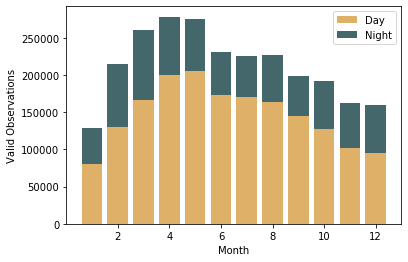

In [122]:
plt.bar(np.arange(1, 13), day, color = '#deb068', label = 'Day')
plt.bar(np.arange(1, 13), night, bottom = day, color = '#43676b', label = 'Night')
plt.xlabel('Month')
plt.ylabel('Valid Observations')
plt.legend()